# Домашняя работа
Изменить нейронную сеть следующим образом:
 - Чтобы она решала задачу не бинарной классификации, а многоклассовой (Для этого нужно использовать другую лосс функцию и функцию активации на выходе)
 - Чтобы в ней было не 2 скрытых слоя, а три
 - Чтобы кол-во нейронов подставлялось через массив, поданный при инициализации класса модели
 - Чтобы происходил dropout (вероятность 0.3) до первого скрытого слоя. Показать, как это изменение повлияло на результат работы модели на тестовой выборке.
 - Посчитать метрики классификации через classification report (sklearn) для каждого класса

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from tqdm import tqdm
import seaborn as sns

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Подготовка данных для использования
 - Получение Датасета
 - Получение Даталоадера
 - Просмотр данных

In [3]:
train_dataset = datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform=ToTensor()
)
test_dataset = datasets.MNIST(
    root = './data',
    train = False,
    transform=ToTensor()
)

In [4]:
BATCH_SIZE = 64

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=8, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=8, pin_memory=True)

In [6]:
### Целевое значение
next(iter(train_dataloader))[1]

tensor([6, 4, 8, 7, 7, 4, 7, 0, 1, 8, 1, 7, 7, 0, 5, 2, 3, 2, 7, 9, 8, 8, 8, 1,
        6, 7, 0, 8, 6, 2, 1, 8, 6, 0, 7, 0, 7, 9, 7, 4, 1, 1, 3, 1, 5, 5, 5, 8,
        3, 9, 4, 1, 6, 8, 7, 8, 5, 6, 1, 1, 1, 1, 9, 4])

In [7]:
### Torch tensor
next(iter(train_dataloader))[0].shape

torch.Size([64, 1, 28, 28])

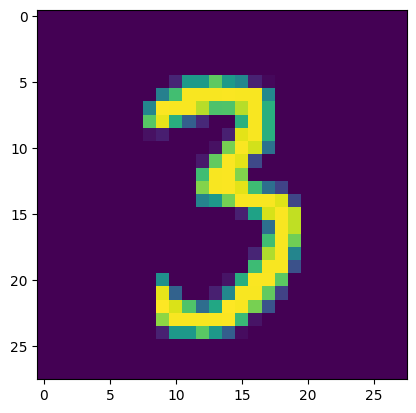

In [8]:
for_show = next(iter(train_dataloader))[0]
plt.imshow(for_show.numpy()[0][0])

### Построим нейронную сеть, чтобы для решения задачи многоклассовой классфикации

In [9]:
class NumberClassificate(torch.nn.Module):
    def __init__(self, inputs_count=28*28, outputs_count=10, hidden_layers=[256, 64, 32], use_dropout=False, device="cpu"):
        super().__init__()

        self.dropout = torch.nn.Dropout(p=0.3)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim=1)
        self.use_dropout = use_dropout

        self.layers = torch.nn.ModuleList([torch.nn.Linear(inputs_count, hidden_layers[0])])
        for layer_outputs_index in range(1, len(hidden_layers)):
            self.layers.append(torch.nn.Linear(
                hidden_layers[layer_outputs_index-1], hidden_layers[layer_outputs_index], device=device))

        self.last_layer = torch.nn.Linear(
            hidden_layers[len(hidden_layers)-1], outputs_count, device=device)

    def forward(self, x):
        x = x.squeeze(1)
        x = x.flatten(1)

        is_first_layer = True

        for layer in self.layers:
            x = layer(x)
            x = self.relu(x)
            if (is_first_layer and self.use_dropout):
                # dropout (вероятность 0.3) происходит до первого скрытого слоя
                x = self.dropout(x)
                is_first_layer = False

        x = self.last_layer(x)
        x = self.softmax(x)
        return x


In [10]:
model = NumberClassificate(28*28, 10, [256, 64, 32], device=device)
model.to(device)

NumberClassificate(
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
  (last_layer): Linear(in_features=32, out_features=10, bias=True)
)

### Функция, вычисляющая лосс

In [11]:
loss_function = torch.nn.MSELoss()

### Оптимизатор

In [12]:
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.05) # при lr < 0.01 обучение очень медленно

### Построим процесс обучения нейронной сети

In [13]:
NUM_EPOCHS = 200

In [14]:
def create_target(nums):
    result = []
    for n in nums:
        target = []
        for i in range(0,10):
            target.append(1.0 if i == n else 0.0)
        result.append(target)
    return torch.FloatTensor(result)

In [15]:
torch.backends.cudnn.benchmark = True
train_loss = []
test_loss = []
pbar = tqdm(range(NUM_EPOCHS))
for epoch in pbar:
    model.train(True)
    train_loss_epoch = 0
    test_loss_epoch = 0
    for X, y in train_dataloader:
        X, target = X.to(device, non_blocking=True), create_target(y).to(device, non_blocking=True)
        model.zero_grad()
        predictions = model.forward(X)
        loss_value = loss_function(predictions, target)
        loss_value.backward()
        train_loss_epoch += loss_value.item()/len(train_dataloader)
        optimizer.step()
    train_loss.append(train_loss_epoch)
    model.train(False)
    with torch.no_grad():
        for X, y in test_dataloader:
            X, target = X.to(device, non_blocking=True), create_target(y).to(device, non_blocking=True)
            predictions = model.forward(X)
            loss_value = loss_function(predictions, target)
            test_loss_epoch += loss_value.item()/len(test_dataloader)
    test_loss.append(test_loss_epoch)
    pbar.set_postfix_str(
        s=f"Train Loss: {round(train_loss[-1],5)}, Test Loss: {round(test_loss[-1],5)}", refresh=True)


100%|██████████| 200/200 [19:54<00:00,  5.97s/it, Train Loss: 0.00142, Test Loss: 0.00392]


<AxesSubplot: >

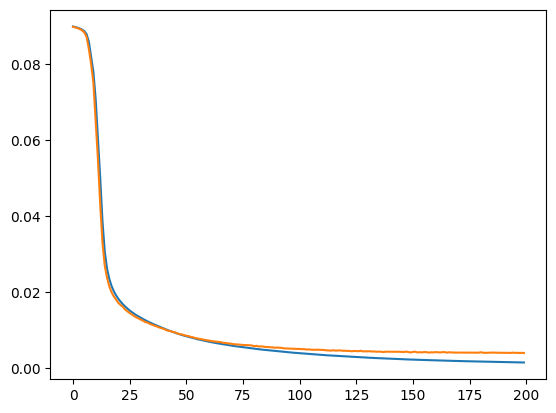

In [16]:
sns.lineplot(train_loss)
sns.lineplot(test_loss)

In [17]:
preds = []
reals = []
model.eval()
for X, y in test_dataloader:
    X = X.to(device)
    predictions = model(X).argmax(dim=1, keepdim=True)
    preds.append(predictions.cpu().detach().numpy())
    reals.append(y.int().numpy())

In [18]:
preds = np.concatenate(preds)
reals = np.concatenate(reals)

In [19]:
from sklearn.metrics import accuracy_score, f1_score

In [20]:
accuracy_score(preds, reals), f1_score(reals, preds, average="weighted")

(0.9744591346153846, 0.9744518175783835)

### Модель с dropout

In [21]:
model = NumberClassificate(28*28, 10, [256, 64, 32], use_dropout=True, device=device)
model.to(device)

NumberClassificate(
  (dropout): Dropout(p=0.3, inplace=False)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=32, bias=True)
  )
  (last_layer): Linear(in_features=32, out_features=10, bias=True)
)

In [22]:
optimizer = torch.optim.SGD(params = model.parameters(), lr = 0.05)

In [23]:
torch.backends.cudnn.benchmark = True
train_loss = []
test_loss = []
pbar = tqdm(range(NUM_EPOCHS))
for epoch in pbar:
    model.train(True)
    train_loss_epoch = 0
    test_loss_epoch = 0
    for X, y in train_dataloader:
        X, y = X.to(device, non_blocking=True), create_target(y).to(device)
        model.zero_grad()
        predictions = model.forward(X)
        loss_value = loss_function(predictions, y)
        loss_value.backward()
        train_loss_epoch += loss_value.item()/len(train_dataloader)
        optimizer.step()
    train_loss.append(train_loss_epoch)
    model.train(False)
    with torch.no_grad():
        for X, y in test_dataloader:
            X, target = X.to(device, non_blocking=True), create_target(y).to(device, non_blocking=True)
            predictions = model.forward(X)
            loss_value = loss_function(predictions, target)
            test_loss_epoch += loss_value.item()/len(test_dataloader)
    test_loss.append(test_loss_epoch)
    pbar.set_postfix_str(
        s=f"Train Loss: {round(train_loss[-1],5)}, Test Loss: {round(test_loss[-1],5)}", refresh=True)


100%|██████████| 200/200 [19:54<00:00,  5.97s/it, Train Loss: 0.00236, Test Loss: 0.00331]


<AxesSubplot: >

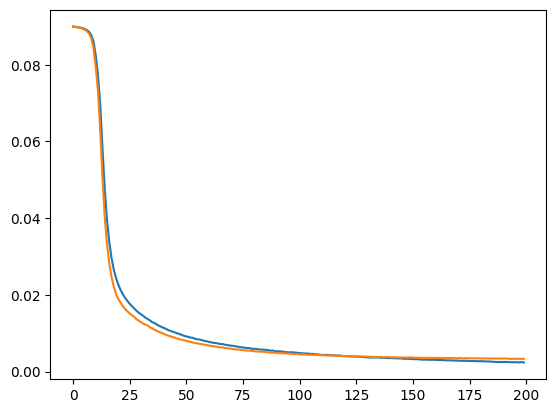

In [24]:
sns.lineplot(train_loss)
sns.lineplot(test_loss)

In [25]:
preds = []
reals = []
model.eval()
for X, y in test_dataloader:
    X = X.to(device)
    predictions = model(X).argmax(dim=1, keepdim=True)
    preds.append(predictions.cpu().detach().numpy())
    reals.append(y.int().numpy())
preds = np.concatenate(preds)
reals = np.concatenate(reals)

In [26]:
accuracy_score(preds, reals), f1_score(reals, preds, average="weighted")

(0.9789663461538461, 0.9789536197983286)

### Заключение

`dropout` позвляет не сущесвенно (на 0.5%) повысить точность работы модели.